In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [387]:
users_df = pd.read_csv(os.getcwd() + '\\takehome_users.csv',encoding='ISO-8859-1')

In [388]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [389]:
users_df.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

#### If user was not invited by another user (null), -1 to indicate this

In [390]:
#users_df['invited_by_user_id'] = users_df['invited_by_user_id'].fillna(-1).astype('int64')
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')

In [391]:
users_df.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object

In [393]:
users_engagement_df = pd.read_csv(os.getcwd() + '\\takehome_user_engagement.csv')

In [394]:
users_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [395]:
users_engagement_df['time_stamp'] = pd.to_datetime(users_engagement_df['time_stamp'])
users_engagement_df = users_engagement_df.sort_values(by='time_stamp',ascending=True)
users_engagement_df

,time_stamp,user_id,visited
178140,2012-05-31 08:20:06,10012,1
59486,2012-05-31 15:47:36,3428,1
175638,2012-05-31 17:19:37,9899,1
26821,2012-05-31 21:58:33,1693,1
109716,2012-06-01 00:17:30,6102,1
...,...,...,...
84316,2014-06-04 23:32:13,4625,1
162633,2014-06-04 23:34:04,9325,1
168409,2014-06-04 23:46:31,9558,1
6053,2014-06-04 23:56:26,341,1


In [396]:
from datetime import datetime, timedelta

# Using login timestamps based on user_id, identify if there is a 7 day period with 3 or more unique logins
# also return number of 7 day periods with > 3 counts, and total number of unique days, and peak num_logins within 7 day period

def count_7days(user_df):
    time_series = sorted(user_df['time_stamp'].unique())
    
    is_active = False
    num_periods = 0
    weekly_counts = []

    
    for timestamp in time_series:
        seven_days = timestamp + timedelta(days=7)
        count = sum(1 for ts in time_series if timestamp < ts <= seven_days)
        if count >= 3:
            is_active = True
            num_periods += 1
        weekly_counts.append(count)
        
    return [is_active, num_periods, len(user_df), max(weekly_counts)]

# Feature Creation:
1) 'is_active' -- (bool) If there has been a 7 day period where you have logged in 3 times.  
2) 'num_weekly_3_counts' -- (int) The number of 'activity periods' you have logged, calculating an 'activity peri/od' same as 'is_active'  
3) 'unique_logins'  -- (int) The number of unique logins per user  
4) 'weekly_peak'  -- (int) Highest number of logins within a 7 day period

In [398]:
user_groups = users_engagement_df.groupby('user_id')

user_id_data = {}

for user, user_df in user_groups:
    user_id_data[user] =  count_7days(user_df) + [user_df['user_id'].unique()[0]]
user_metrics = pd.DataFrame.from_dict(user_id_data, orient='index', columns=['is_active', 'num_weekly_3_counts', 'user_activity', 'weekly_peak', 'user_id'])
user_metrics    

,is_active,num_weekly_3_counts,user_activity,weekly_peak,user_id
1,False,0,1,0,1
2,False,0,14,2,2
3,False,0,1,0,3
4,False,0,1,0,4
5,False,0,1,0,5
...,...,...,...,...,...
11996,False,0,1,0,11996
11997,False,0,1,0,11997
11998,False,0,1,0,11998
11999,False,0,1,0,11999


#### 70% of users, 6235 / 8823, have only logged in once

In [399]:
user_metrics['user_activity'].value_counts(normalize=True) * 100

user_activity
1      70.667573
2       3.853565
3       2.731497
4       2.051456
5       1.246741
         ...    
332     0.011334
86      0.011334
395     0.011334
509     0.011334
255     0.011334
Name: proportion, Length: 402, dtype: float64

In [400]:
user_metrics['user_activity'].value_counts()

user_activity
1      6235
2       340
3       241
4       181
5       110
       ... 
332       1
86        1
395       1
509       1
255       1
Name: count, Length: 402, dtype: int64

#### 15% of users are considered 'active'

In [401]:
user_metrics['is_active'].value_counts(normalize=True) * 100

is_active
False    84.823756
True     15.176244
Name: proportion, dtype: float64

In [402]:
user_metrics['is_active'].value_counts()

is_active
False    7484
True     1339
Name: count, dtype: int64

In [403]:
user_metrics[user_metrics['user_activity'] > 1]['is_active'].value_counts(normalize=True) * 100

is_active
True     51.738794
False    48.261206
Name: proportion, dtype: float64

In [404]:
user_metrics[user_metrics['user_activity'] > 1]['is_active'].value_counts()

is_active
True     1339
False    1249
Name: count, dtype: int64

#### Of the 30% of users with more than 1 Login (2558),51.7% (1339) are considered 'active' 

In [406]:
merged_users = pd.merge(users_df, user_metrics[['is_active', 'user_id', 'user_activity']], left_on='object_id', right_on='user_id')
merged_users = merged_users.set_index('object_id')
merged_users.index.name = None
merged_users

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_active,user_id,user_activity
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,1,1
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,False,2,14
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False,3,1
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False,4,1
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,False,11996,1
11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,False,11997,1
11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,False,11998,1
11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,False,11999,1


#### Account Age Feature:  
>days_since_creation - Days from creation_time day until 06/06/2014   
days_since_login - Days from last_session_creation day until 06/06/2014

In [407]:
today

Timestamp('2014-06-06 14:58:50')

In [408]:
today = merged_users.last_session_creation_time.max()

merged_users['days_since_creation'] = (today - merged_users['creation_time']).dt.days
merged_users['days_since_login'] = (today - merged_users['last_session_creation_time']).dt.days                               

## Referred User Features:
1) Referred By Active User (bool)  -- If a user's referred user is considered 'active'
2) Referred User Activity (int) -- The number of unique logins of your referred user  
3) Referred User Org id (str) -- the org of the referred user
3) Referred Account Age (int) -- days_since_creation of referred user

In [409]:
active_user_mapping = merged_users.set_index('user_id')['is_active']
merged_users['referred_by_active_user'] = merged_users['invited_by_user_id'].map(active_user_mapping).fillna(False).astype(bool)

In [410]:
referred_user_org = merged_users.set_index('user_id')['org_id']
merged_users['referred_user_org'] = merged_users['invited_by_user_id'].map(referred_user_org).fillna('-1').astype(str)

In [411]:
unique_logins_mapping = merged_users.set_index('user_id')['user_activity']
merged_users['referred_user_activity'] = merged_users['invited_by_user_id'].map(unique_logins_mapping).fillna(0).astype('int64')

In [412]:
age_map = merged_users.set_index('user_id')['days_since_creation']
merged_users['referred_user_age'] = merged_users['invited_by_user_id'].map(age_map).fillna(0).astype('int64')

In [413]:
merged_users.org_id.value_counts()

org_id
0      228
1      172
2      150
3      125
4      122
      ... 
396      6
400      6
397      5
386      4
416      2
Name: count, Length: 417, dtype: int64

In [417]:
merged_users.creation_source.value_counts()

creation_source
ORG_INVITE            3188
SIGNUP                1898
GUEST_INVITE          1588
SIGNUP_GOOGLE_AUTH    1385
PERSONAL_PROJECTS      764
Name: count, dtype: int64

In [415]:
merged_users.dtypes

creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
is_active                               bool
user_id                                int64
user_activity                          int64
days_since_creation                    int64
days_since_login                       int64
referred_by_active_user                 bool
referred_user_org                     object
referred_user_activity                 int64
referred_user_age                      int64
dtype: object

In [418]:
merged_users.referred_by_active_user = merged_users.referred_by_active_user.astype(bool)
merged_users.creation_source = merged_users.creation_source.astype(str)
merged_users.org_id = merged_users.org_id.astype(str)
merged_users.opted_in_to_mailing_list = merged_users.opted_in_to_mailing_list.astype(bool)
merged_users.enabled_for_marketing_drip = merged_users.enabled_for_marketing_drip.astype(bool)

In [419]:
cat_feats = ['opted_in_to_mailing_list','enabled_for_marketing_drip', 'referred_by_active_user']
num_feats = ['referred_user_age','referred_user_activity','user_activity', 'days_since_creation','days_since_login']
dummy_feats = ['creation_source', 'org_id']
target = ['is_active']

In [420]:
merged_users[cat_feats+dummy_feats+num_feats].dtypes

opted_in_to_mailing_list        bool
enabled_for_marketing_drip      bool
referred_by_active_user         bool
creation_source               object
org_id                        object
referred_user_age              int64
referred_user_activity         int64
user_activity                  int64
days_since_creation            int64
days_since_login               int64
dtype: object

In [750]:
merged_users.select_dtypes(include='bool').columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'is_active',
       'referred_by_active_user'],
      dtype='object')

# Chi Square Test

In [421]:
X_c = pd.get_dummies(merged_users[dummy_feats])
X = pd.concat([X_c, merged_users[cat_feats+num_feats]], axis=1)
y = merged_users['is_active']

In [422]:
from sklearn.feature_selection import chi2

chi2_values, p_values = chi2(X, y)

# Create a DataFrame for the results
chi2_df = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Value': chi2_values,
    'P Value': p_values
})

In [423]:
len(chi2_df[chi2_df['P Value'] <= 0.05])

41

In [705]:
chi2_df[chi2_df['P Value'] <= 0.05].sort_values(by='Chi2 Value', ascending=False)

,Feature,Chi2 Value,P Value
427,user_activity,998680.513525,0.000000e+00
429,days_since_login,278466.889632,0.000000e+00
428,days_since_creation,22761.464776,0.000000e+00
426,referred_user_activity,7876.009281,0.000000e+00
425,referred_user_age,2220.362357,0.000000e+00
424,referred_by_active_user,32.828368,1.006650e-08
5,org_id_0,18.979070,1.321602e-05
0,creation_source_GUEST_INVITE,18.804793,1.448028e-05
157,org_id_235,15.607549,7.794281e-05
325,org_id_387,13.244156,2.734309e-04


In [503]:
active_users = merged_users[merged_users.is_active == True]
non_active_users = merged_users[merged_users.is_active == False]

## #1 Indicators of 'Active' User: More logins, Older Accounts
1) Higher number of unique logins  
2) Less Days since Active Session
3) Higher Account age   
  
  These are fairly obvious, mathematical factors as the greater of the number of logins, and longer the account has been active, the more likely to experience an 'active' period of 3 logins within 7 days.

In [694]:
chi2_df[chi2_df['P Value'] <= 0.05].sort_values(by='Chi2 Value', ascending=False).head(3)

,Feature,Chi2 Value,P Value
427,user_activity,998680.513525,0.0
429,days_since_login,278466.889632,0.0
428,days_since_creation,22761.464776,0.0


## #2 Referred User Activity Increases User Activity

In [703]:
chi2_df[chi2_df['P Value'] <= 0.05].sort_values(by='Chi2 Value', ascending=False)[3:6]

,Feature,Chi2 Value,P Value
426,referred_user_activity,7876.009281,0.000000e+00
425,referred_user_age,2220.362357,0.000000e+00
424,referred_by_active_user,32.828368,1.006650e-08


In [542]:
active_corr = merged_users['is_active'].astype(int).corr(merged_users['referred_by_active_user'].astype(int))
activity_corr = merged_users['user_activity'].corr(merged_users['referred_user_activity'])
print('Correlation for referral user and user is ' + str(round(active_corr,4)) + ' for active rating')
print('Correlation for referral user and user is ' + str(round(activity_corr,4)) + ' for number of unique logins')


Correlation for referral user and user is 0.0637 for active rating
Correlation for referral user and user is 0.0846 for number of unique logins


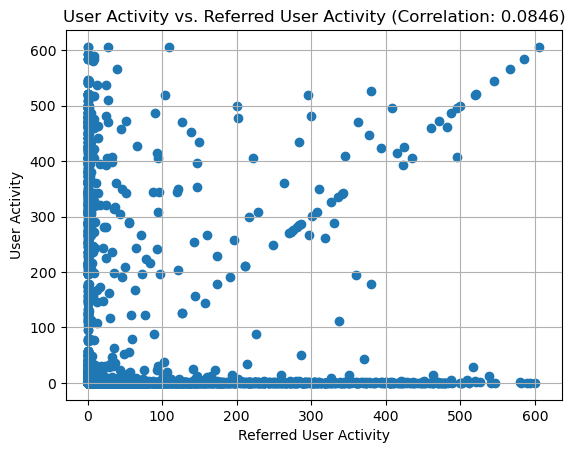

In [550]:
plt.scatter(merged_users['user_activity'].astype(int), merged_users['referred_user_activity'].astype(int))
plt.xlabel('Referred User Activity')
plt.ylabel('User Activity')
plt.title(f'User Activity vs. Referred User Activity (Correlation: {activity_corr:.4f})')

plt.grid(True)

plt.show()

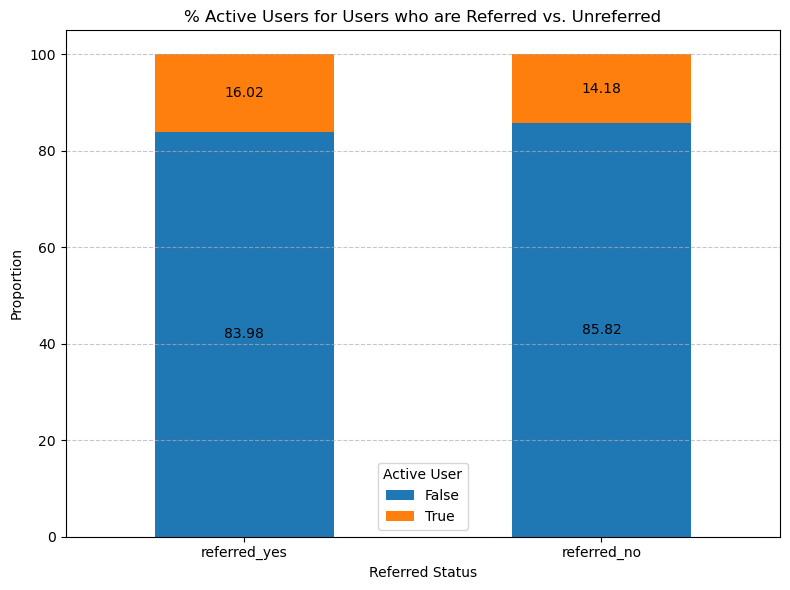

In [688]:
no_ref_df = merged_users[merged_users['invited_by_user_id'].isnull()]
yes_ref_df = merged_users[~merged_users['invited_by_user_id'].isnull()]

yes_mean_active = pd.DataFrame(yes_ref_df.is_active.value_counts(normalize=True) *100).rename(columns={'proportion':'referred_yes'})
no_mean_active = pd.DataFrame(no_ref_df.is_active.value_counts(normalize=True)*100).rename(columns={'proportion':'referred_no'})

mean_active_df = pd.concat([yes_mean_active,no_mean_active],axis=1)
plt.figure(figsize=(8, 6))
ax = mean_active_df.T.plot(kind='bar', stacked=True, ax=plt.gca())

# Add labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center')

# Add labels and title
plt.xlabel('Referred Status')
plt.ylabel('Proportion')
plt.title('% Active Users for Users who are Referred vs. Unreferred')
plt.legend(title='Active User')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0) 

# Show plot
plt.tight_layout()
plt.show()

In [559]:
print('Active Users: Mean Referred User Activity: ' + str(round(active_users.referred_user_activity.mean(),2)))
print('Non-Active Users: Mean Referred User Activity: ' + str(round(non_active_users.referred_user_activity.mean(),2)))

Active Users: Mean Referred User Activity: 35.19
Non-Active Users: Mean Referred User Activity: 22.23


## #3 Org_Id

In [656]:
org_group = merged_users.groupby('org_id')

org_dc = {}

for org, org_df in org_group:
    org_dc[org] = org_df['is_active'].value_counts(normalize=True)*100
org_activity = pd.DataFrame(org_dc).T
org_activity.columns = org_activity.columns.astype(str)
org_activity.index.Name = None

### Empty Organizations:

In [676]:
inactive_orgs = org_activity[(org_activity['True'] == 100) | (org_activity['True'].isnull())].index
inactive_orgs.to_list()

['151',
 '183',
 '237',
 '242',
 '272',
 '279',
 '299',
 '307',
 '308',
 '310',
 '329',
 '346',
 '348',
 '349',
 '355',
 '362',
 '365',
 '374',
 '386',
 '394',
 '396',
 '412',
 '416']

## Least Active Organizations

In [680]:
org_activity.dropna().sort_values(by='False', ascending=False).head(10)

is_active,False,True
36,97.368421,2.631579
51,96.551724,3.448276
86,95.652174,4.347826
80,95.238095,4.761905
0,95.175439,4.824561
369,95.000000,5.000000
26,95.000000,5.000000
204,94.736842,5.263158
143,94.736842,5.263158
147,94.444444,5.555556


<Figure size 1000x600 with 0 Axes>

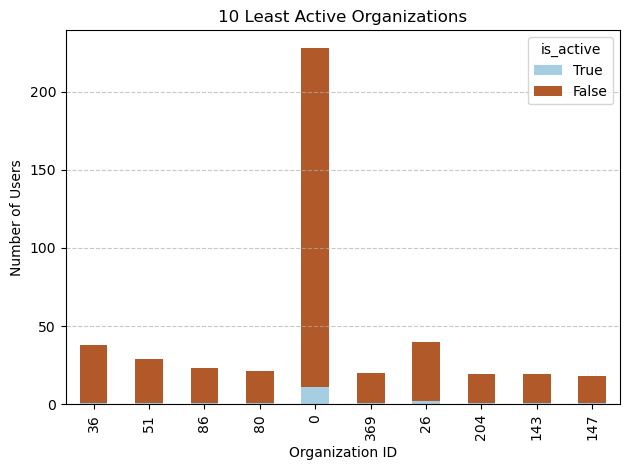

In [687]:
inactive_orgs = org_activity.dropna().sort_values(by='False', ascending=False).head(10).index

plot_data = []
for org_id in inactive_orgs:
    subset = merged_users[merged_users['org_id'] == org_id]
    counts = subset['is_active'].value_counts().reindex([True, False], fill_value=0)
    plot_data.append(counts)

plot_df = pd.DataFrame(plot_data, index=inactive_orgs)

plt.figure(figsize=(10, 6))
plot_df.plot(kind='bar', stacked=True, colormap='Paired')

plt.xlabel('Organization ID')
plt.ylabel('Number of Users')
plt.title('10 Least Active Organizations')
plt.legend(title='is_active')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Most Active Organizations

In [754]:
org_activity.dropna().sort_values(by='True', ascending=False).head(10)

is_active,False,True
235,40.000000,60.000000
273,44.444444,55.555556
387,45.454545,54.545455
161,50.000000,50.000000
400,50.000000,50.000000
399,50.000000,50.000000
270,53.846154,46.153846
280,54.545455,45.454545
395,57.142857,42.857143
248,58.333333,41.666667


TypeError: 'str' object is not callable

<Figure size 1000x600 with 0 Axes>

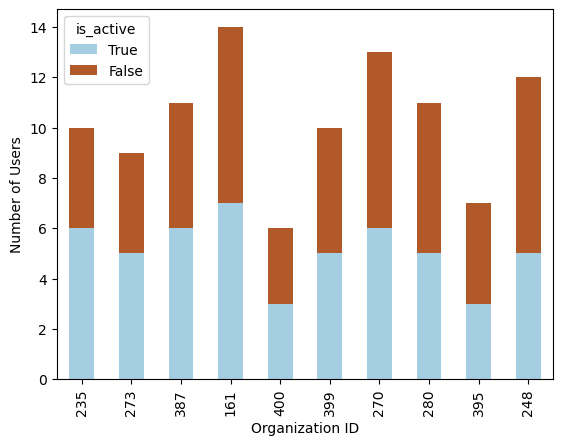

In [742]:
org_ids_to_plot = org_activity.dropna().sort_values(by='True', ascending=False).head(10).index

plot_data = []
for org_id in org_ids_to_plot:
    subset = merged_users[merged_users['org_id'] == org_id]
    counts = subset['is_active'].value_counts().reindex([True, False], fill_value=0)
    plot_data.append(counts)

plot_df = pd.DataFrame(plot_data, index=org_ids_to_plot)

plt.figure(figsize=(10, 6))
plot_df.plot(kind='bar', stacked=True, colormap='Paired')

plt.xlabel('Organization ID')
plt.ylabel('Number of Users')
plt.title('10 Most Active Organizations')
plt.legend(title='is_active')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### Mean Proportion of Active Users (15%)  
These orgs are very active, but are generally smaller organizations (note the y-axis maximum of 14 users)

## Creation Sources: GUEST_INVITE, SIGNUP

In [700]:
chi2_df[(chi2_df['P Value'] <= 0.05) & (chi2_df.Feature.str.contains('creation_source'))].sort_values(by='Chi2 Value', ascending=False)

,Feature,Chi2 Value,P Value
0,creation_source_GUEST_INVITE,18.804793,0.000014
3,creation_source_SIGNUP,5.026629,0.024960


In [722]:
source_df = merged_users.groupby('creation_source')

source_dc = {}

for source, source_df in source_df:
    source_dc[source] = source_df['is_active'].value_counts(normalize=True)*100
source_activity = pd.DataFrame(source_dc).T
source_activity.columns = source_activity.columns.astype(str)
source_activity

is_active,False,True
GUEST_INVITE,80.919395,19.080605
ORG_INVITE,85.508156,14.491844
PERSONAL_PROJECTS,82.460733,17.539267
SIGNUP,86.670179,13.329821
SIGNUP_GOOGLE_AUTH,86.498195,13.501805


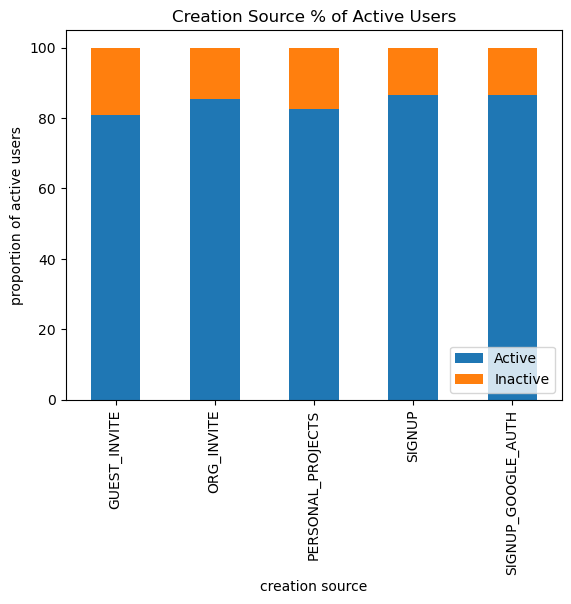

In [737]:
ax = source_activity.plot(kind='bar',title='Creation Source % of Active Users', stacked=True)
plt.legend(['Active', 'Inactive'],loc='lower right')
plt.xlabel('creation source')
plt.ylabel('proportion of active users')
plt.show()

#### While Guest_invite and Signup are still considered statistically significant, there is not much variance based on creation_source

## Least Important: opted into mailing list, enabled for marketing drip

In [752]:
chi2_df[chi2_df.Feature.isin(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'referred_by_active_user'])]

,Feature,Chi2 Value,P Value
422,opted_in_to_mailing_list,0.233325,6.290694e-01
423,enabled_for_marketing_drip,0.036595,8.482917e-01
424,referred_by_active_user,32.828368,1.006650e-08


In [782]:
def boolcol_values(df, boolcol1, boolcol2):

    mask_true = df[df[boolcol1] == True]
    mask_false = df[df[boolcol1] == False]

    bool_true = mask_true[boolcol2].value_counts(normalize=True)*100
    bool_false = mask_false[boolcol2].value_counts(normalize=True)*100

    df_true = pd.DataFrame(bool_true).rename(columns={'proportion': boolcol1 + '_True'}).T
    df_false = pd.DataFrame(bool_false).rename(columns={'proportion': boolcol1 + '_False'}).T

    return pd.concat([df_true,df_false])

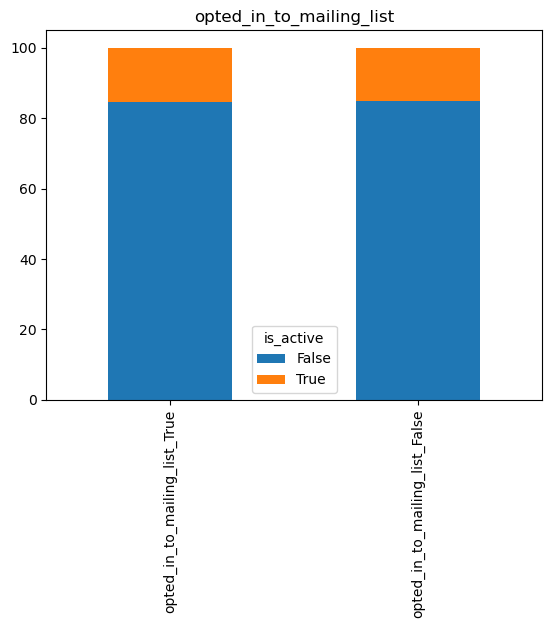

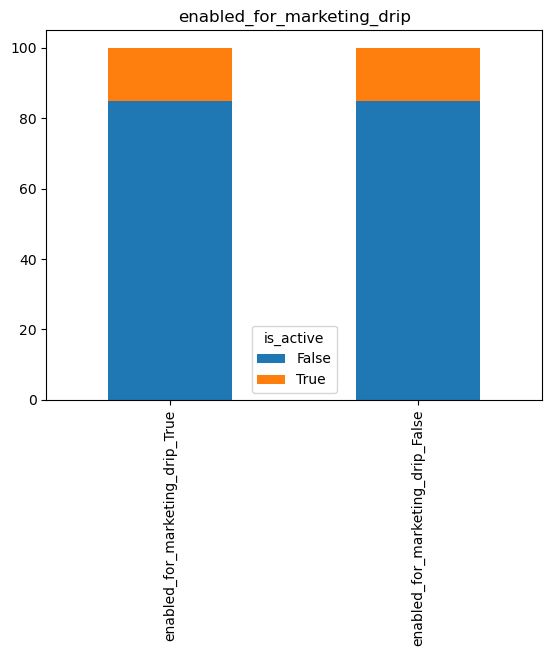

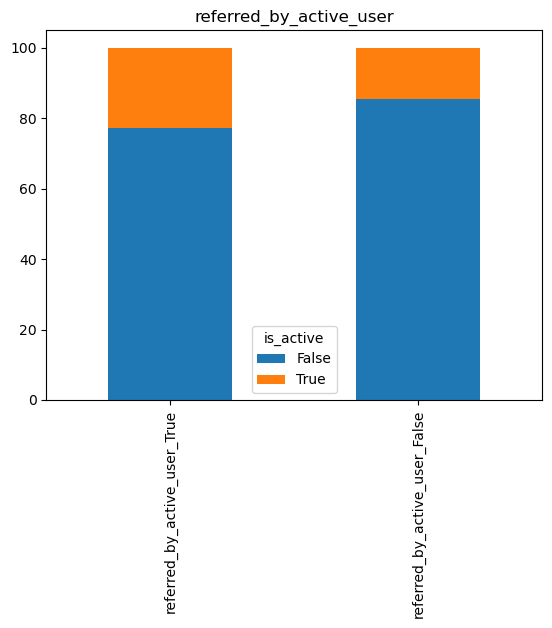

In [789]:
for col in ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'referred_by_active_user']:
    boolcol_values(merged_users,  col, 'is_active').plot(kind='bar', stacked=True, title=col)

## Conclusion: Only referred by active user is important, enabled for marketing drip and opting into mailing list is unimportant

## Org IDs that are unimportant
They do not have a meaningful relationship with 'is_active' users

In [760]:
chi2_df.sort_values(by='Chi2 Value').head(50)

,Feature,Chi2 Value,P Value
368,org_id_50,0.000016,0.996841
193,org_id_268,0.000438,0.983294
23,org_id_114,0.000438,0.983294
281,org_id_347,0.000438,0.983294
168,org_id_245,0.000438,0.983294
170,org_id_247,0.000438,0.983294
272,org_id_339,0.000438,0.983294
121,org_id_202,0.000438,0.983294
181,org_id_257,0.000438,0.983294
139,org_id_219,0.000438,0.983294


# Random Forest

In [605]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sc=MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

smote = SMOTE(random_state=42)
X_trainSM, y_trainSM = smote.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(n_estimators=200)
rf_sm = rf_model.fit(X_trainSM, y_trainSM)

# Top 25 Features

In [761]:
rf_sm_df = pd.DataFrame({
    'feature' : X.columns,
    'importance' : rf_sm.feature_importances_})

rf_sm_df = rf_sm_df.sort_values(by='importance',ascending=False).reset_index(drop=True).set_index('feature')
rf_sm_df.head(25)

,importance
feature,
user_activity,0.524444
days_since_login,0.287853
days_since_creation,0.056988
referred_user_activity,0.007139
referred_user_age,0.006287
org_id_0,0.003932
org_id_1,0.002603
creation_source_GUEST_INVITE,0.002534
opted_in_to_mailing_list,0.002426


### opted_in_to_mailing list is important for predictions despite not having a relationship with 'is_active' as measured by chi_squared statistics

# Top Org IDs

In [763]:
rf_sm_df[rf_sm_df.index.str.contains('org_id')].head(25)

,importance
feature,
org_id_0,0.003932
org_id_1,0.002603
org_id_2,0.002407
org_id_62,0.002304
org_id_7,0.002086
org_id_196,0.001666
org_id_235,0.001519
org_id_3,0.001435
org_id_4,0.001311


# Conclusion
>Model Quality: Not great, as shown by metrics below. More features needed to increase accuracy of predictions. Or, it may be a tricky variable to predict. Overall user activity is influenced by referred user activity, but it is a rather weak correlation. Org_id is a valuable indicator overall of user activity. Smaller organizations such as 235, 273, and 383 are very active while large organizations such as 0,1,2,3,4,6 are very inactive. Mailing List, Marketing Drip, and creation_source are weak indicators that barely deviate from the mean 'is_active' proportion. 

In [161]:
y_predSM = rf_sm.predict(X_test)

# Calculate metrics
precisionSM = precision_score(y_test, y_predSM)
recallSM = recall_score(y_test, y_predSM)

# Classification report
reportSM = classification_report(y_test, y_predSM)

# Confusion matrix
conf_matrixSM = confusion_matrix(y_test, y_predSM)

# Display the results
print("Precision (SM):", precisionSM)
print("Recall (SM):", recallSM)
print("\nClassification Report (SM):\n", reportSM)
print("Confusion Matrix (SM):\n", conf_matrixSM)

Precision (SM): 0.2
Recall (SM): 0.0951219512195122

Classification Report (SM):
               precision    recall  f1-score   support

       False       0.85      0.93      0.89      2237
        True       0.20      0.10      0.13       410

    accuracy                           0.80      2647
   macro avg       0.52      0.51      0.51      2647
weighted avg       0.75      0.80      0.77      2647

Confusion Matrix (SM):
 [[2081  156]
 [ 371   39]]


## Creation Source: 'Org_Invite' as an important predictive feature, despite having average chi-squared relationship with 'is_active'

In [743]:
rf_sm_df[rf_sm_df.index.str.contains('creation_source')]

,importance
feature,
creation_source_GUEST_INVITE,0.002534
creation_source_ORG_INVITE,0.002078
creation_source_SIGNUP,0.001735
creation_source_SIGNUP_GOOGLE_AUTH,0.001464
creation_source_PERSONAL_PROJECTS,0.000943


C:\Users\mitch\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mitch\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


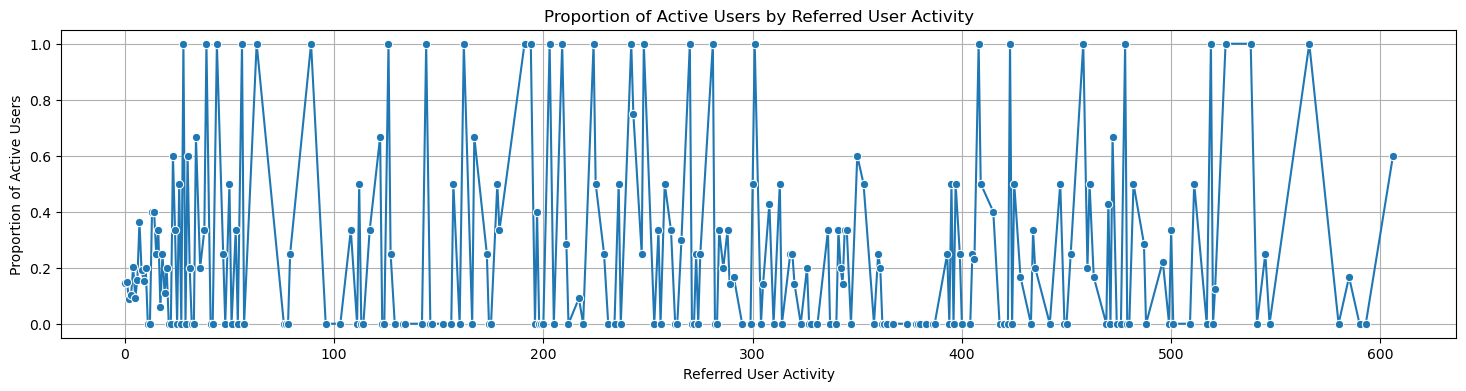

In [301]:
import seaborn as sns


# Calculate the proportion of active users for each 'referred_user_activity'
proportion_df = merged_users.groupby('referred_user_activity')['is_active'].mean().reset_index()

# Rename the columns for clarity
proportion_df.columns = ['referred_user_activity', 'proportion_active']

# Plotting
plt.figure(figsize=(18, 4))
sns.lineplot(x='referred_user_activity', y='proportion_active', data=proportion_df, marker='o')
plt.title('Proportion of Active Users by Referred User Activity')
plt.xlabel('Referred User Activity')
plt.ylabel('Proportion of Active Users')
plt.grid(True)
plt.show()
